# Modelling approach

The modelling approach here is to iterate over a list of classifiers and run a grid search with 10 fold cross validation.

The 10 fold cross validation approach is used because we need to work around the fact that there are only `3000` labelled observations and we can now use all of them to train and evaluate model performance.

In [1]:
# Reload local modules as they are changing a lot
%load_ext autoreload
%autoreload 2
import warnings

# Deprecations and pandas slice warnings due to the train_test split
warnings.filterwarnings('ignore')

Load in data from the `DATA_DIR` and start with features (X) and target (y)

In [2]:
from trainer_lib import DataManager
from trainer_lib.utils.notebook_config import DATA_DIR, REPORT_DIR
# The instantiation will fetch the data and documentation
mngr = DataManager(save_path=DATA_DIR, report_path=REPORT_DIR)
X,y = mngr.train
X_test, _ = mngr.train


The code below will train the following classifiers on the training data:

- Linear SVM
- Decision Tree 
- Random Forest 
- Neural Net
- AdaBoost
- Naive Bayes
- XGB

In [4]:
from trainer_lib.modelling.train import Trainer, Evaluation, Explain
from trainer_lib.utils.notebook_config import MODEL_DIR
from trainer_lib.modelling.model_config import GRID_SEARCH, MODEL_POST_URL
trainer = Trainer(X,y, GRID_SEARCH, MODEL_DIR)
trainer.train("Friday Morning!!!")

Output()

In [23]:
trainer()

Note: the score improved from 0.92 to 0.93 on the XGBoost model by filling the `DaysPassed` feature's negative values with the median.

## Model interpretability



With a linear model, the coefficients associated with each variable give an intuitive picture of how the effect the target variable.
With boosted methods such as `XGboost` the internals of the model are more difficult to explain. This can be a problem when the prediction from a model needs to be interpreted and acted upon by a person!

There is a great library for explaining complex models called `shap` which I will use to explain not just the model, but individual predictions also.

Here I will use shap's `summary` plot to visualize the effect the features have on the model.

How to read the plot:
- The vertical access represents the ***importance*** of a feature (higher = more important)
- The horizontal access represents the ***values of the features*** ( left = lower values, right = higher values)
- The color of the points indicates the ***outcome as a function of the feature at that value*** (pink = sale, blue = no-sale)

The following are my observations:

1. The `CallDurationMins` feature is the more influential on the outcome of the call (purchase of car insurance or not) which makes sense intuitively. <br>The longer the call duration, the more likely a sale is. <br>**This information should be considered carefully** because the call duration is a strongly linked to the customer's willingness to participate. It is unlikely that the bank are hanging up abruptly! With that in mind, this feature could be looked at in further detail to see where the bank can act on this information. A check to carry out might be to split the feature into windows. There could be a window of maybe < 2 minutes where a customer is just not interested and cuts the call short (this is something we have no **real** control over), then once your call lasts past this threshold (2 minutes being an arbitrary example here) the longer you talk to them the higher chances of making the sale. This is something the bank can incorporate into their campaign training internally.
3. The `LastContactMonth` feature is the next most influential. There has a non-linear relationship as can be seen from the EDA notebook. The earlier months of the year result in less sales, then around spring the outcome is more positive and into summer again, higher chances. In Autumn the 

**The following code will only work for XGBOOST as the classifier**

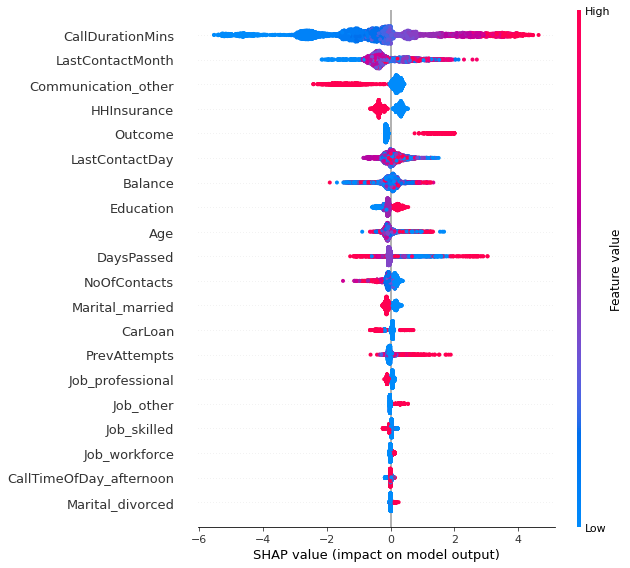

In [24]:
import matplotlib.pyplot as plt
import shap
explain = Explain(trainer.best_classifier, X)
explain.summary()

# Prediction

As the trained models are pickled and saved, the FastAPI REST interface (available at http://localhost:3007/docs#/) will be used for predictions.

This has the advantage of recording in an SQLlite DB the predictons

The `Predict` class has all the logic to get this prediction (given a row of data from either the train or test set).

In the API prediction endpoint, there is some logic to provide an explanation with the prediction. This explanation is based on a rough calculation of the expected value from making the call.

This is just an example of adding some context to the predition for whoever wull be using the information. It is also an example of looking at the business context when assessing model output.

The logic is as follows:

    ((The probability of success * the potential gain ) x (potential lifetime value multiplier for first time customer)) - ( 1 - probability of succss * cost of calling )

This explanation / advice is then returned to the client (this notebook in this case)

In [91]:
from trainer_lib.modelling.predict import Predict
model_id = "c70bf73a9c0d967982b32b9af07d66b9261adbb3"
predict = Predict(X.iloc[:10], model_id)
r = predict()

In [99]:
from rich.console import Console
from rich.table import Table

table = Table(title="Prediction results", expand=True)

table.add_column("id", justify="right", no_wrap=True)
table.add_column("prediction", justify="right")
table.add_column("Explanation")

for p in r.json():
    table.add_row(str(p['id']), str(p['prediction']), p['explanation'], style="green" if p['prediction'] else "red")

console = Console()
table

## Explaining a prediction

The below plot will show in a sort of intuitive way the different effects certain feature values have on an individual prediciton.

**This could be incorporated into the API response as an improvement**

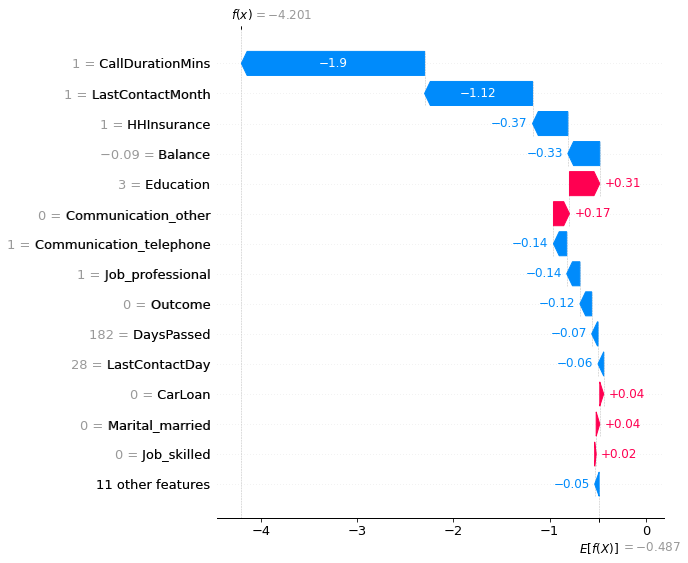

In [94]:
explain.waterfall(0)